In [1]:
!pip install mne -q


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import mne
from mne.preprocessing import ICA
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
class EEGConfig:
    def __init__(self):
        self.root_dir = "./data" # download from https://gigadb.org/dataset/100990
        self.results_dir = "./epochs_fif"   # directory to save processed epochs

        self.subjects = [f"sub{str(i).zfill(2)}" for i in range(1, 26)]  # subjects 01 to 25

        self.tmin, self.tmax = -0.2, 0.8
        self.baseline = (-0.2, 0.0)

        self.l_freq = 0.1    
        self.h_freq = 20.0     
        self.notch_freq = 50.0

        self.event_dict_config = {
            "frequent_codes": [5],
            "target_code": 6,
        }

        self.target_channels = [
            "Fz", "Cz",
            "P3", "Pz", "P4",
            "PO7", "PO8", "POz",
            "Oz"
        ]

        os.makedirs(self.results_dir, exist_ok=True)


config = EEGConfig()
print(f"Config loaded. Subjects: {len(config.subjects)}")

Config loaded. Subjects: 1


In [4]:
def filter_data(raw, l_freq=0.1, h_freq=20.0, notch_freq=50.0):
    raw_filt = raw.copy()
    raw_filt.filter(l_freq=l_freq, h_freq=h_freq, verbose=False)
    raw_filt.notch_filter(freqs=notch_freq, verbose=False)
    return raw_filt

In [5]:
def run_ica_and_clean(raw_filt, n_components=20):
    ica = ICA(
        n_components=n_components,
        random_state=3407,
        max_iter="auto",
        method="fastica",
    )
    ica.fit(raw_filt, verbose=False)
    try:
        eog_inds, _ = ica.find_bads_eog(raw_filt, verbose=False)
    except Exception:
        eog_inds = []
    ica.exclude = eog_inds
    raw_clean = ica.apply(raw_filt.copy(), verbose=False)
    return raw_clean, ica

In [6]:
def infer_event_codes(event_id, config):
    all_codes = list(event_id.values())
    freq_candidates = [
        c for c in config.event_dict_config["frequent_codes"]
        if c in all_codes
    ]
    targ_code = config.event_dict_config["target_code"]
    if len(freq_candidates) == 0 or targ_code not in all_codes:
        raise ValueError(f"Event code mismatch. Available: {event_id}")
    return {"frequent": freq_candidates, "target": targ_code}

In [7]:
def create_epochs(raw_clean, config):
    events, event_id = mne.events_from_annotations(raw_clean, verbose=False)
    event_codes = infer_event_codes(event_id, config)

    event_map = {
        "frequent": event_codes["frequent"][0],
        "target": event_codes["target"],
    }

    picks = mne.pick_channels(
        raw_clean.info["ch_names"],
        include=config.target_channels,
        ordered=True,
    )

    epochs = mne.Epochs(
        raw_clean,
        events,
        event_id=event_map,
        tmin=config.tmin,
        tmax=config.tmax,
        baseline=config.baseline,          # baseline -0.2..0s
        picks=picks,
        preload=True,
        reject_by_annotation=True,
        verbose=False,
    )

    y = np.isin(epochs.events[:, 2], event_codes["target"]).astype(int)
    return epochs, y, event_codes

In [8]:
def balance_epochs(epochs, y, random_state=3407):
    rng = np.random.RandomState(random_state)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    n_min = min(len(idx_0), len(idx_1))
    if n_min == 0:
        raise RuntimeError("One class has 0 trials, cannot balance.")

    idx_sel = np.concatenate([
        rng.choice(idx_0, n_min, replace=False),
        rng.choice(idx_1, n_min, replace=False),
    ])
    rng.shuffle(idx_sel)

    epochs_bal = epochs[idx_sel]
    y_bal = y[idx_sel]
    return epochs_bal, y_bal

In [9]:
def plot_raw_vs_filtered(raw, raw_filt, channels, start_time=0.0, duration=10.0):
    picks = mne.pick_channels(raw.info['ch_names'], include=channels, ordered=True)
    if len(picks) == 0:
        print("Channel not found:", channels)
        return

    sfreq = raw.info['sfreq']
    n_samples = int(duration * sfreq)
    t = np.arange(n_samples) / sfreq

    raw_data, _ = raw[picks, int(start_time * sfreq):int((start_time + duration) * sfreq)]
    filt_data, _ = raw_filt[picks, int(start_time * sfreq):int((start_time + duration) * sfreq)]
    ch_names = [raw.ch_names[i] for i in picks]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    plt.suptitle("EEG before vs after filtering", fontsize=14)

    offset = np.arange(len(ch_names)) * 80.0  

    # Before filtering
    for i, ch in enumerate(ch_names):
        axes[0].plot(t, raw_data[i] * 1e6 + offset[i], label=ch)
    axes[0].set_title("Before filtering")
    axes[0].set_ylabel("Amplitude (µV)")
    axes[0].legend(loc="upper right", fontsize=8, ncol=4)
    axes[0].grid(True)

    # After filtering
    for i, ch in enumerate(ch_names):
        axes[1].plot(t, filt_data[i] * 1e6 + offset[i], label=ch)
    axes[1].set_title("After filtering")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude (µV)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


[1/1] sub01 ...


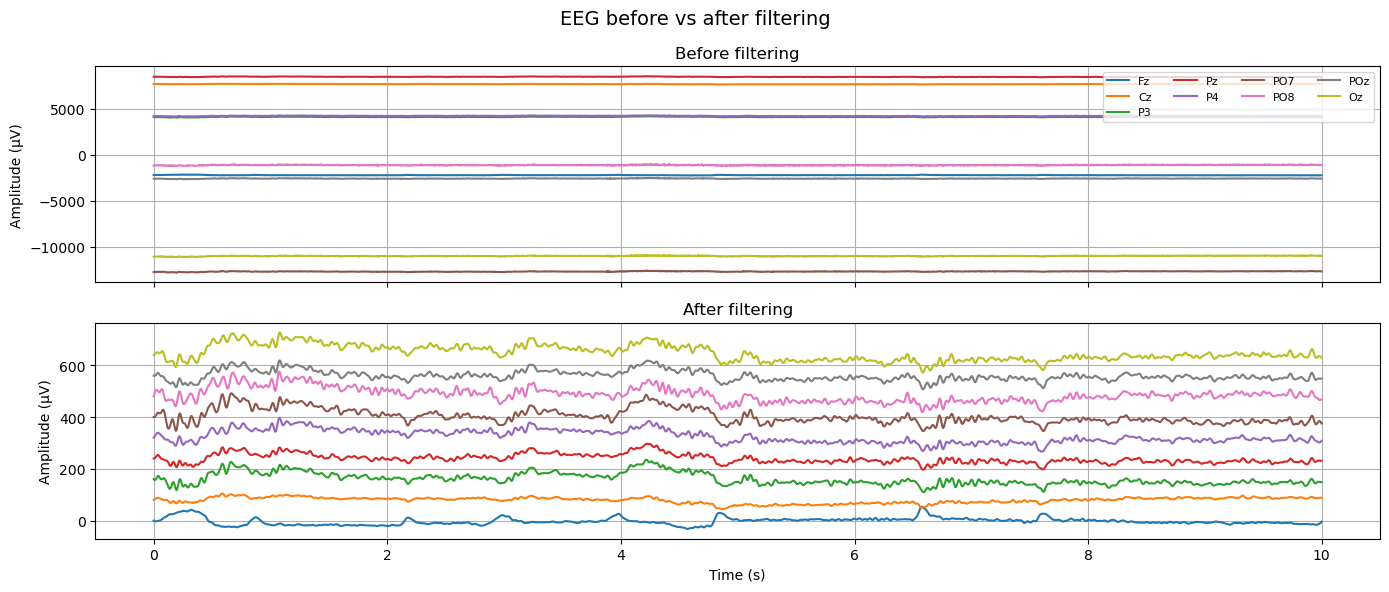

Using matplotlib as 2D backend.


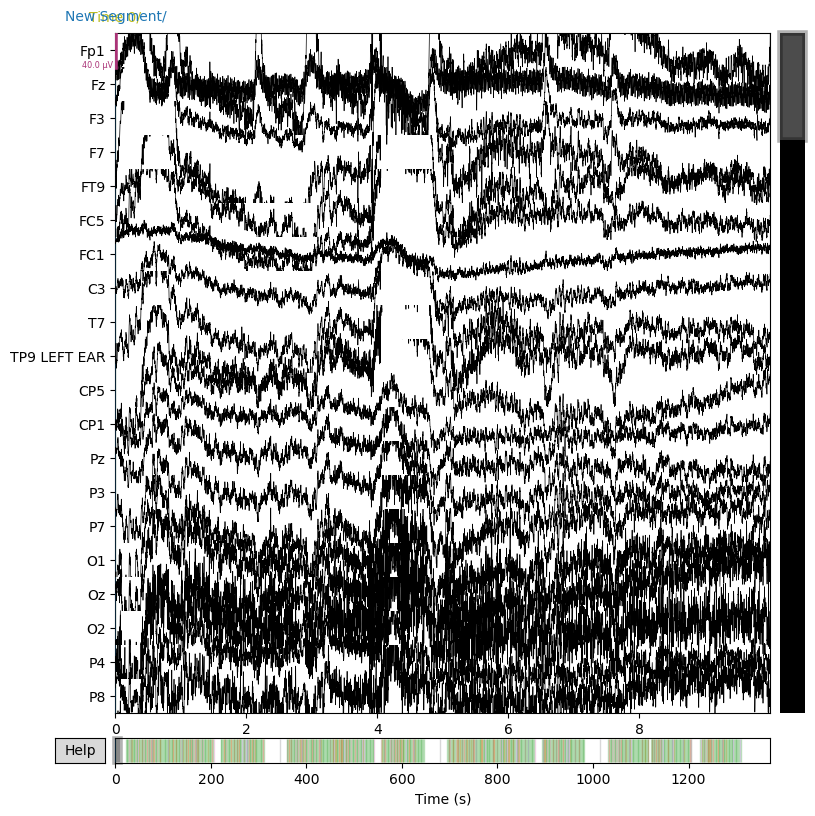

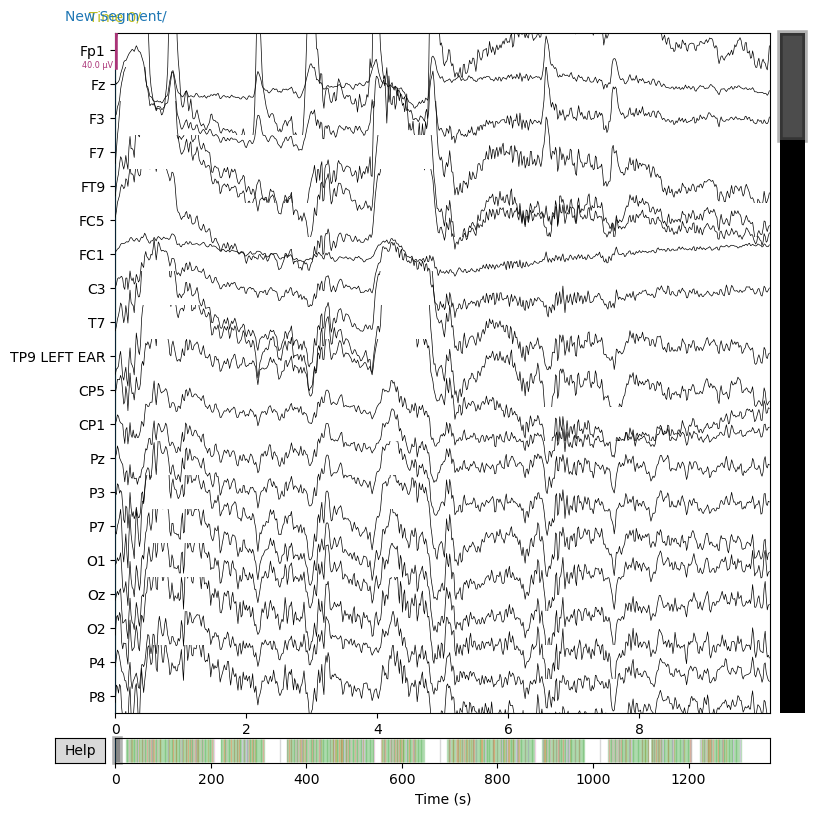

Epochs before balance: 579 (Frequent=498, Target=81)
After balance: 162 (Frequent=81, Target=81)
Saving balanced epochs to: ./epochs_fif\sub-01_epo.fif

Summary (balanced epochs per subject):
sub01: N=162, Frequent=81, Target=81


In [10]:
all_counts = []

for sub_idx, sub in enumerate(config.subjects):
    vhdr_path = os.path.join(
        config.root_dir,
        sub,
        f"sub-{sub[-2:]}_task-oddball_eeg.vhdr",
    )
    if not os.path.exists(vhdr_path):
        print(f"[{sub_idx+1}/{len(config.subjects)}] Skip {sub}: file not found")
        continue

    print(f"\n[{sub_idx+1}/{len(config.subjects)}] {sub} ...")

    raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)
    try:
        raw.set_montage("standard_1020", match_case=False, on_missing="ignore")
    except Exception:
        pass

    raw_filt = filter_data(
        raw,
        l_freq=config.l_freq,
        h_freq=config.h_freq,
        notch_freq=config.notch_freq,
    )

    if sub_idx == 0:
        plot_raw_vs_filtered(
            raw,
            raw_filt,
            channels=["Fz", "Cz", "P3", "Pz", "P4", "PO7", "PO8", "POz", "Oz"], # important channels
            start_time=0.0,
            duration=10.0
        )

        raw.plot(
        start=0, duration=10, n_channels=20,
        title=f"{sub} - Before ICA (10s)", show=True
        )
        raw_filt.plot(
            start=0, duration=10, n_channels=20,
            title=f"{sub} - After ICA (10s)", show=True
        )

    raw_clean, ica = run_ica_and_clean(raw_filt, n_components=20)

    epochs, y, event_codes = create_epochs(raw_clean, config)

    print(
        f"Epochs before balance: {len(y)} "
        f"(Frequent={np.sum(y==0)}, Target={np.sum(y==1)})"
    )

    epochs_bal, y_bal = balance_epochs(epochs, y, random_state=3407)

    print(
        f"After balance: {len(y_bal)} "
        f"(Frequent={np.sum(y_bal==0)}, Target={np.sum(y_bal==1)})"
    )

    all_counts.append(
        (sub, len(y_bal), int(np.sum(y_bal == 0)), int(np.sum(y_bal == 1)))
    )

    epochs_bal.event_id = {"Frequent": 0, "Target": 1}

    events_new = epochs_bal.events.copy()
    events_new[:, 2] = y_bal
    epochs_bal.events = events_new

    out_path = os.path.join(
        config.results_dir,
        f"sub-{sub[-2:]}_epo.fif"
    )
    print(f"Saving balanced epochs to: {out_path}")
    epochs_bal.save(out_path, overwrite=True)

print("\nSummary (balanced epochs per subject):")
for sub, n, nf, nt in all_counts:
    print(f"{sub}: N={n}, Frequent={nf}, Target={nt}")